In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc3 as pm
import arviz as az

sns.set_style("whitegrid")

# Иерархические модели

Предположим, что необходимо проанализировать качество воды в некотором городе, поэтому мы используем выборки на основе разделения городской территории на смежные районы. Предполагается также, что имеются два возможных варианта анализа получаемых данных:
* исследование каждого района как отдельного объекта;
* объединение всех полученных данных и оценка качества воды в городе как в одной большой группе.

Оба варианта могут быть вполне разумными решениями в зависимости от того, что именно мы хотим узнать. 

Можно предпочесть первый вариант, обоновав его тем, что при этом мы получаем более подробную картину задачи, тогда как некоторые подробности могут остаться незамеченными или менее убедительными, если усреднить данные. 

Обоснование второго варианта может состоять в том, что при объединении данных получается выборка более крупного размера, следовательно, более точная оценка. 

В обоих случаях обоснования корректны, но есть возможность выбрать еще и некоторый промежуточный вариант. 
Можно создать модель для оценки качества воды в каждом районе и одновременно оценивать качество воды во всем городе. <br>
Такой тип модели называют иерархической или многоуровневой моделью, так как данные моделируются с использованием иерархической структуры, то есть структуры с несколькими уровнями.

Что нужно для создания иерархической модели? 

Если говорить кратко, то вместо жесткого определения параметров априорных распределений как некоторых постоянных чисел выполняется их оценка непосредственно по исследуемым данным посредством размещения совместно используемых априорных распределений для всех параметров. 

Подобные априорные распределения более высокого уровня часто называют априорными гиперраспределениями, а их параметры – гиперпараметрами (приставка «гипер» происходит от греч. hyper – над, сверх). 

Также возможно размещение априорных распределений над априорными гиперраспределениями, то есть создание любого необходимого количества уровней. Но при этом модель быстро становится трудной для понимания, и если задача в действительности не требует более глубокой структуры, то добавление избыточных уровней не поможет улучшить качество статистических выводов. <br>
С другой стороны, можно окончательно запутаться в переплетении априорных гиперраспределений и гиперпараметров, лишившись возможности какой-либо осмысленной их интерпретации и в определенной степени дискредитируя преимущества статистики, основанной на моделях. 

Основным принципом создания моделей является их полное соответствие смыслу исследуемых данных, и модели прежде всего должны отображать структуру этих данных (и получать соответствующие преимущества).

Для демонстрации основных концепций использования иерархических моделей воспользуемся имитационной моделью из примера об оценке качества воды.

Предположим, что уже собраны образцы воды из трех различных районов города и измерено содержание свинца в этих образцах. 
Образцы с содержанием свинца, превышающим концентрацию, рекомендованную Всемирной организацией здравоохранения (ВОЗ), помечаются нулем, а образцы с нормальным содержанием свинца помечаются единицей.

Сгенерируем данные

In [2]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18] #  [18, 18, 18]  [3,3,3]   [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

print(group_idx)
print(data)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Здесь имитируется эксперимент, где выполнены измерения в трех группах, каждая из которых состоит из определенного количества образцов. Общее число образцов в каждой группе сохранено в списке N_samples. Используя этот список, мы сохраняем записи о количестве образцов с хорошим качеством воды в каждой группе. <br>
Остальной код предназначен для генерации списка данных с заполнением его нулями и единицами.

По существу здесь применяется та же модель, которая использовалась для задачи о подбрасывании монеты, за исключением двух важных характеристик:
* здесь определены два априорных гиперраспределения, на которые воздействует априорное бета-распределение;
* вместо применения априорных гиперраспределений к параметрам $\alpha$ и $\beta$ мы определяем эти априорные гиперраспределения напрямую для $\mu$ – среднего значения бета-распределения и для $k$ – точности (концентрации) бета-распределения. Точность – это аналог значения, обратного стандартному отклонению: чем больше значение $k$, тем более концентрированным будет бета-распределение:

$$ \mu\sim Beta(\alpha_{\mu},\beta_\mu)$$
$$ k \sim |Normal(0,\sigma_k)| $$
$$ \alpha = \mu k$$
$$ \beta = (1-\mu)k$$
$$ \theta \sim Beta(\alpha_{i},\beta_i)$$
$$ y = Bern(\theta_i) $$

Индекса i введен для обозначения обозначения факта существования в модели групп с различными значениями для некоторых параметров.

На диаграмме отчетливо видно, что новая модель содержит один дополнительный уровень по сравнению со всеми ранее используемыми моделями:

 ![](diag03.png)

Обратите внимание на использование на схеме символа "=" вместо символа "\sim" при определении $\alpha_i$ и $\beta_i$, поскольку при известных $\mu$ и κ значения $\alpha_i$ и $\beta_i$ становятся полностью определенными. В соответствии с этим условием мы называем такой тип переменной детерминированным в противоположность стохастическим (случайным) переменным, таким как $\mu$, κ или $\theta$.

Использование среднего значения и точности является математически равнозначным использованию параметризации $alpha$ и $\beta$, подразумевая при этом, что мы должны получить те же результаты. Но почему выбирается этот обходной маневр вместо более прямого пути? Для такого выбора существуют две причины:

* параметризация среднего значения и точности, являясь математически равнозначной, в числовом отношении лучше подходит для сэмплирования, следовательно, мы можем быть более уверенными в правильности результатов (пока как констатация факта)

* данный пример, демонстрирующий потенциальные возможности применения более одного метода выражения модели. Математически равнозначные реализации могут никоим образом не различаться на практике, а единственной подробностью, заслуживающей внимания, является эффективность механизма сэмплирования. Все прочие детали могут представлять лишь вопросы интерпретируемости модели. В некоторых случаях более удачным выбором применение среднего значении бета-распределения, по сравнению с применением напрямую параметров $\alpha$ и $\beta$.

In [3]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', 
                alpha=μ*κ, 
                beta=(1.0-μ)*κ, 
                shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ, κ, μ]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:02<00:00, 3054.51draws/s]


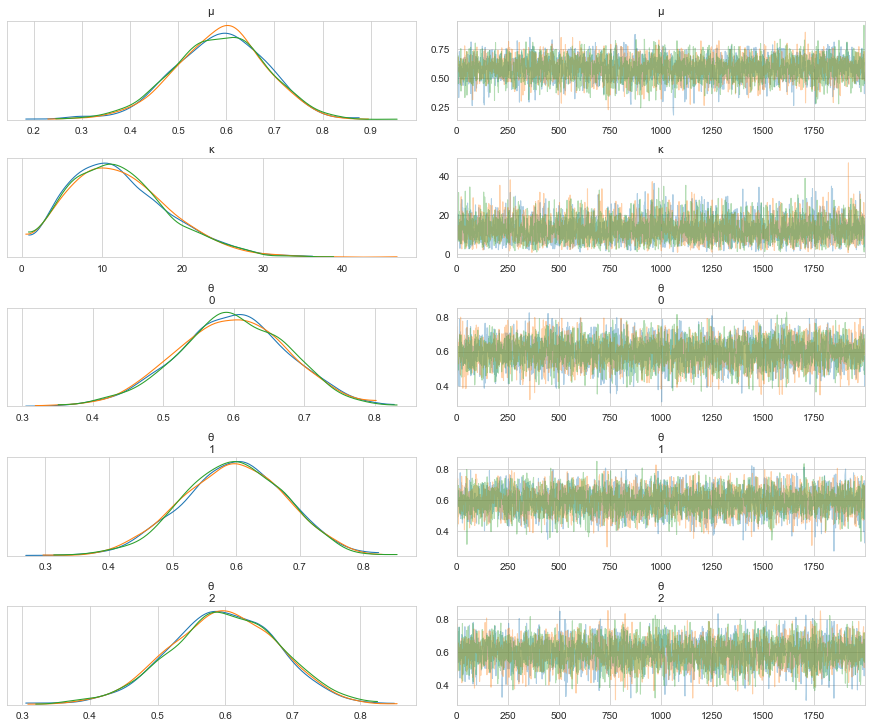

In [4]:
az.plot_trace(trace_h);

In [5]:
az.summary(trace_h)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.585,0.095,0.413,0.763,0.002,0.001,3876.0,3827.0,3872.0,4218.0,1.0
κ,12.183,6.123,1.919,23.478,0.089,0.063,4700.0,4700.0,4199.0,3284.0,1.0
θ[0],0.596,0.078,0.455,0.746,0.001,0.001,4945.0,4873.0,4952.0,3788.0,1.0
θ[1],0.595,0.079,0.445,0.740,0.001,0.001,5019.0,4897.0,4974.0,4340.0,1.0
θ[2],0.597,0.080,0.445,0.743,0.001,0.001,4787.0,4787.0,4820.0,3887.0,1.0


Теперь вернемся к началу и еще два раза выполним код с другими значениями.
Результат будет следующий:
    

|  G_samples |   θ (среднее) |     
|:-----|:----|
| 18, 18, 18 | 0.6, 0.6, 0.6 |
| 3, 3, 3 | 0.11, 0.11, 0.11 |
| 18, 3, 3 | 0.55, 0.13, 0.13 |

В первой строке можно видеть, что для набора данных с 18 «хорошими» образцами из 30 получено среднее значение 0.6 для θ. Напомним, что теперь среднее значение θ – это вектор из трех элементов, по одному для каждой груп- пы. Во второй строке только 3 «хороших» образца из 30, а среднее значение θ равно 0.11. В последней строке наблюдается кое-что интересное и, возможно, неожиданное. Вместо получения комбинации оценок среднего значения θ из предыдущих строк, а именно 0.6, 0.11, 0.11, получены другие значения: 0.55, 0.13, 0.13.

Что произошло? Может быть, это проблема сходимости или какая- то ошибка в определении модели?

Здесь мы наблюдаем редуцирование оценок к обобщенному среднему значению. В общем смысле это положительное явление, которое, несомненно, представляет собой следствие применения выбранной нами модели: используя априорные гиперраспределения, мы оцениваем параметры априорного бета-распределения исследуемых данных, и каждая группа информирует остальные, которые, в свою очередь, получают информацию об оценке других групп. 

Короче говоря, группы эффективно обмениваются информацией через априорное гиперраспределение. В результате мы наблюдаем явление, называемое редуцированием (shrinkage). Этот эффект является следствием частичного объединения данных в общий пул. 

Мы моделируем группы ни как абсолютно независимые друг от друга объекты, ни как единую большую группу. Вместо этого создается некий усредненный вариант.

Чем это может быть полезно? Эффект редуцирования вносит определенный вклад в получение более стабильных статистических выводов. Это во многом похоже на то, что наблюдалось при использовании распределения Стьюдента для обработки промахов, где применялись результаты распределения с медленно убывающими (широкими) хвостами в модели, более устойчивой или менее чувствительной к наличию точек данных, расположенных далеко от среднего значения. 

Ввод априорных гиперраспределений и последующие статистические выводы результатов на высоком уровне  позволяют сделать ее менее чувствительной к экстремальным значениям в отдельных группах.

Для наглядности предположим, что размеры выборок отличаются друг от друга – некоторые меньше, некоторые больше. Чем меньше размер выборки, тем проще получить некорректные результаты. В самом крайнем случае если вы взяли только одну пробу воды в конкретном районе, то, возможно, просто случайно наткнулись на единственный старый свинцовый трубопровод, сохранившийся в этом районе, или наоборот – на единственный трубопровод, сделанный из поливинилхлорида. В первом случае имеет место переоценка плохого качества воды, во втором – недооценка. При использовании иерархической модели некорректная оценка по одной группе будет улучшена с помощью информации, предоставленной другими группами. Разумеется, больший размер выборки также оказывает положительное влияние, но зачастую этот вариант недоступен.

Конечно, размер эффекта редуцирования зависит от данных: группа с большим объемом данных будет сильнее влиять на оценку других групп, чем группа с меньшим количеством точек данных. Если несколько групп одинаковы, а одна группа отличается от них, то одинаковые группы будут информировать друг друга о своей одинаковости и подкреплять общую оценку. В то же время одинаковые группы будут подтягивать оценку менее похожей на них группы, это как раз тот случай, о котором говорилось в предыдущем примере.


### Визуальное сравнение параметров моделей

Мы будем сравнивать результаты с помощью функции <code>plot_forest</code> из библиотеки ArviZ. В эту функцию можно передавать более одной модели. Это удобно, если необходимо сравнивать значения параметров из различных моделей, как в нашем примере. Отметим, что в данном случае передается несколько аргументов в функцию <code>plot_forest</code> для получения требуемого графика, например <code>combined=True</code> для объединения результатов из всех цепочек.

In [12]:
N_samples = [30, 30, 30]
G_samples = [18, 3, 3] 

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)
    θ = pm.Beta('θ', 
                alpha=μ*κ, 
                beta=(1.0-μ)*κ, 
                shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_h = pm.sample(2000)

with pm.Model() as model_ho:
    θ = pm.Beta('θ', 
                alpha=1, 
                beta= 1, 
                shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_ho = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ, κ, μ]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:02<00:00, 2940.20draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:01<00:00, 5321.11draws/s]


In [13]:
az.summary(trace_h)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.299,0.110,0.111,0.513,0.002,0.001,4628.0,4294.0,4674.0,4035.0,1.0
κ,5.883,3.770,0.463,12.752,0.060,0.042,3969.0,3969.0,3742.0,3994.0,1.0
θ[0],0.549,0.087,0.387,0.713,0.001,0.001,4826.0,4785.0,4847.0,4368.0,1.0
θ[1],0.129,0.059,0.028,0.235,0.001,0.001,4946.0,4946.0,4650.0,3846.0,1.0
θ[2],0.130,0.058,0.028,0.231,0.001,0.001,5304.0,5304.0,4994.0,3626.0,1.0


In [14]:
az.summary(trace_ho)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ[0],0.593,0.085,0.431,0.746,0.001,0.001,6522.0,6397.0,6458.0,4382.0,1.0
θ[1],0.125,0.057,0.029,0.229,0.001,0.000,7366.0,6648.0,7171.0,4642.0,1.0
θ[2],0.125,0.058,0.028,0.238,0.001,0.001,6453.0,5420.0,6200.0,3652.0,1.0


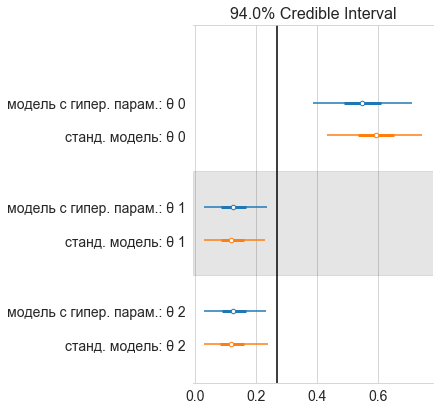

In [16]:
fig = az.plot_forest([trace_h, trace_ho],
               model_names=['модель с гипер. парам.', 'станд. модель'],
                var_names='θ', 
                combined=True);
y_lims = fig[0].get_ylim();
fig[0].vlines(trace_h['θ'].mean(), *y_lims);

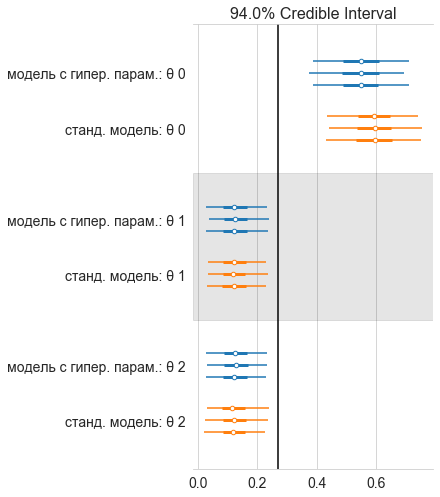

In [17]:
fig = az.plot_forest([trace_h, trace_ho],
               model_names=['модель с гипер. парам.', 'станд. модель'],
                var_names='θ', 
                combined=False);
y_lims = fig[0].get_ylim();
fig[0].vlines(trace_h['θ'].mean(), *y_lims);

Тут приведем пример визуального оценивания априорного распределения иерархической модели:

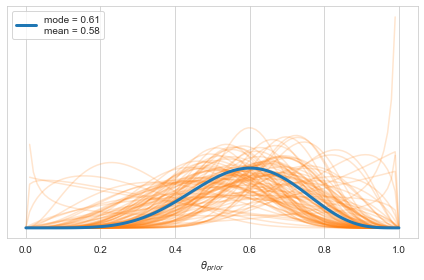

In [6]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

А вот тут редуцирование отсутствует 

In [5]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18] 

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

with pm.Model() as model_ho:
    θ = pm.Beta('θ', 
                alpha=1, 
                beta= 1, 
                shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_ho = pm.sample(2000)

az.summary(trace_ho)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:01<00:00, 5761.12draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ[0],0.593,0.087,0.433,0.754,0.001,0.001,7393.0,7356.0,7364.0,4497.0,1.0
θ[1],0.595,0.089,0.431,0.761,0.001,0.001,7391.0,7253.0,7323.0,4393.0,1.0
θ[2],0.593,0.086,0.433,0.751,0.001,0.001,7967.0,7967.0,8081.0,4094.0,1.0


In [6]:
N_samples = [30, 30, 30]
G_samples = [3, 3, 3] 

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

with pm.Model() as model_ho:
    θ = pm.Beta('θ', 
                alpha=1, 
                beta= 1, 
                shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_ho = pm.sample(2000)

az.summary(trace_ho)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:01<00:00, 5389.77draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ[0],0.127,0.059,0.028,0.237,0.001,0.001,6713.0,5925.0,6486.0,4046.0,1.0
θ[1],0.126,0.059,0.024,0.232,0.001,0.001,5818.0,5158.0,5710.0,4382.0,1.0
θ[2],0.125,0.058,0.028,0.237,0.001,0.001,6075.0,5912.0,5428.0,3490.0,1.0


In [7]:
N_samples = [30, 30, 30]
G_samples = [18, 3, 3] 

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

with pm.Model() as model_ho:
    θ = pm.Beta('θ', 
                alpha=1, 
                beta= 1, 
                shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_ho = pm.sample(2000)

az.summary(trace_ho)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:01<00:00, 5437.75draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ[0],0.595,0.085,0.439,0.756,0.001,0.001,7140.0,6997.0,7091.0,4542.0,1.0
θ[1],0.126,0.058,0.030,0.233,0.001,0.001,6698.0,5912.0,6600.0,4300.0,1.0
θ[2],0.126,0.057,0.030,0.233,0.001,0.001,7193.0,6209.0,7107.0,4194.0,1.0
